<div class="fluid-row" id="section-header">
    <h2 class="title toc-ignore">Master Data Science & Big Data - ENSIAS</h2>
    <h4 class="author"><em>pacman</em></h4>
    <h4 class="date"><em>February 7, 2018</em></h4>
</div>
<center>
    <h1>
        <u>Cars Price Predictor</u>
    </h1>
    <h4>Realized by : Ayoub RMIDI <br></h4>
</center>
<div class="fluid-row" id="section-header">
    <h2 class="title toc-ignore">Introduction</h2>
    <p class="lead">In this notebook I will build a multiple regression model that can predict cars price based on multiple features such as mileage, mark, model, model_year, fuel_type and the city, the data I will work with was extracted from a famous ads platform called <a href="https://www.avito.ma">Avito</a>. The notebook will be presented as follow : 
    </p>
    <ul class="lead">
        <li>Data collection</li>
        <li>Data Preprocessing & Cleansing</li>
        <li>Exploratory data analysis & Visualisation</li>
        <li>Data Modeling</li>
        <li>Evaluting the Model</li>
    </ul>
</div>

## Data collection

In [3]:
# data colelction and preprocessing
from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
# for data visualisation and statistical analysis
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set_style("white")
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

/home/pacman/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
def get_ads_urls():
    urls_list = []
    # define the basic url to crawl on
    basic_url = "https://www.avito.ma/fr/maroc/voitures-à_vendre?mpr=500000000&o="
    # loop over the paginated urls
    for i in range(1,250):
        # get the page url
        url = basic_url+str(i)
        # get the request response
        r  = requests.get(url)
        data = r.text
        # transform it to bs object
        soup = BeautifulSoup(data, "lxml")
        # loop over page links
        for div in soup.findAll('div', {'class': 'item-img'}):
            a = div.findAll('a')[0]
            urls_list.append(a.get('href'))


    df = pd.DataFrame(data={"url": urls_list})
    df.to_csv("./data/ads_urls.csv", sep=',',index=False)

In [ ]:
# get the ads urls and save them in a file
get_ads_urls()

In [4]:
def scrap_ad_data(ad_url):
    r = requests.get(ad_url)
    data = r.text
    soup = BeautifulSoup(data, "html.parser")
    target_component = soup.findAll("h2",  {"class": ["font-normal", "fs12", "no-margin", "ln22"]})
    # create a list that will hold our component data
    results = []
    for i in target_component:
        results.append(''.join(i.findAll(text=True)).replace('\n',''))
    return results

In [5]:
def write_data_to_csv(data):
    with open("./data/output.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [8]:
# read the saved urls file as a dataframe 
urls_data = pd.read_csv("./data/ads_urls.csv")
# create  a list that will hold the final data
final_result = []
i = 1
# loop over the dataframe
for index, row in urls_data.iterrows():
    final_result.append(scrap_ad_data(row['url']))
    # to count how many page we have processed since qe have 35 links per page
    #i += 1
    #if i%100 == 0:
    #    print("page ",i, "done")
print('Scrapping data finished')
# now that we have all the data we can write it in a csv file
write_data_to_csv(final_result)

Scrapping data finished


## Data Preprocessing & Cleansing

<p class="lead">So now we have the RAW data very well gathered, the next step is to preprocess these dataset in order ta make it useful for visualization and training session.</p>
<p class="lead">First of all we read our data set into a data frame, so that we can manipulate it easily ...</p>

In [4]:
# set the column names
colnames=['price', 'year_model', 'mileage', 'fuel_type', 'mark', 'model', 'fiscal_power', 'sector', 'type', 'city'] 
# read the csv file as a dataframe
df = pd.read_csv("./data/output.csv", sep=",", names=colnames, header=None)
# let's get some simple vision on our dataset
df.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,sector,type,city
0,135 000 DH,Année-Modèle:2013,Kilométrage:160 000 - 169 999,Type de carburant:Diesel,Marque:Peugeot,Modèle:508,Puissance fiscale:-,-,"Type:Voitures, Offre",Temara
1,53 000 DH,Année-Modèle:2008,Kilométrage:35 000 - 39 999,Type de carburant:Diesel,Marque:Renault,Modèle:Clio,Puissance fiscale:-,-,"Type:Voitures, Offre",Safi
2,59 000 DH,Année-Modèle:2007,Kilométrage:180 000 - 189 999,Type de carburant:Diesel,Marque:Citroen,Modèle:C3,Puissance fiscale:6 CV,Secteur:oued_fes,"Type:Voitures, Offre",Fès
3,88 000 DH,Année-Modèle:2010,Kilométrage:35 000 - 39 999,Type de carburant:Diesel,Marque:Mercedes-Benz,Modèle:220,Puissance fiscale:-,-,"Type:Voitures, Offre",Nador
4,60 000 DH,Année-Modèle:2009,Kilométrage:130 000 - 139 999,Type de carburant:Essence,Marque:Ford,Modèle:Fiesta,Puissance fiscale:7 CV,Secteur:saies,"Type:Voitures, Offre",Fès


### Starting the Preprocessing

<p class="lead">The first thing I have to do is to clean unwanted strings from my columns, then change it to the appropriate type since all of them are string values and finally drop unwanted columns such as sector, type, fiscal_power.</p>

#### Price Columns

<p class="lead">One thing I have noticed is that there are some ads that were published without the price, so the first thing to do is to delete those rows.</p>

In [5]:
# remove thos rows doesn't contain the price value
df = df[df.price.str.contains("DH") == True]
# remove the 'DH' caracters from the price
df.price = df.price.map(lambda x: x.rstrip('DH'))
# remove the space on it
df.price = df.price.str.replace(" ","")
# change it to integer value
df.price = pd.to_numeric(df.price, errors = 'coerce', downcast= 'integer')

#### Year Model

In [6]:
# remove thos rows doesn't contain the year_model value
df = df[df.year_model.str.contains("Année-Modèle") == True]
# remove the 'Année-Modèle:' from the year_model
df.year_model = df.year_model.map(lambda x: x.lstrip('Année-Modèle:').rstrip('ou plus ancien'))
# df.year_model = df.year_model.map(lambda x: x.lstrip('Plus de '))
# remove those lines having the year_model not set
df = df[df.year_model != ' -']
df = df[df.year_model != '']
# change it to integer value
df.year_model = pd.to_numeric(df.year_model, errors = 'coerce', downcast = 'integer')

#### mileage

<p class="lead">One of the tips I will `mileage` feature engineering is to calculate the mean of it, since I have 2 values the min and the max, so I decided to take the mean so that it could be more explicative in that sence, instead of choosing the minimum or the maximum. </p>

In [7]:
# remove thos rows doesn't contain the year_model value
df = df[df.mileage.str.contains("Kilométrage") == True]
# remove the 'Kilométrage:' string from the mileage feature 
df.mileage = df.mileage.map(lambda x: x.lstrip('Kilométrage:'))
df.mileage = df.mileage.map(lambda x: x.lstrip('Plus de '))
# remove those lines having the mileage values null or '-'
df = df[df.mileage != '-']
# we have only one value type that is equal to 500 000, all the other ones contain two values
if any(df.mileage != '500 000'):
    # create two columns minim and maxim to calculate the mileage mean
    df['minim'], df['maxim'] = df.mileage.str.split('-', 1).str
    # remove spaces from the maxim & minim values 
    df['maxim'] = df.maxim.str.replace(" ","")
    df['minim'] = df.minim.str.replace(" ","")
    df['maxim'] = df['maxim'].replace(np.nan, 500000)
    # calculate the mean of mileage 
    df.mileage = df.apply(lambda row: (int(row.minim) + int(row.maxim)) / 2, axis=1)
    # now that the mileage is calculated so we do not need the minim and maxim values anymore
    df = df.drop(columns=['minim', 'maxim'])

#### Fuel type

In [8]:
# remove the 'Type de carburant:' string from the carburant_type feature
df.fuel_type = df.fuel_type.map(lambda x: x.lstrip('Type de carburant:'))

#### Mark & Model

In [9]:
# remove the 'Marque:' string from the mark feature
df['mark'] = df['mark'].map(lambda x: x.replace('Marque:', ''))
df = df[df.mark != '-']
# remove the 'Modèle:' string from model feature 
df['model'] = df['model'].map(lambda x: x.replace('Modèle:', ''))

#### fiscal power

<p class="lead">For the fiscal power we can see that there is exactly 5728 rows not announced, so we will fill them by the mean of the other columns, since it is an important feature in cars price prediction so we can not drop it.</p>

In [10]:
df.fiscal_power.value_counts()

Puissance fiscale:-                5624
Puissance fiscale:6 CV             1011
Puissance fiscale:8 CV              692
Puissance fiscale:7 CV              495
Puissance fiscale:9 CV              207
Puissance fiscale:11 CV             115
Puissance fiscale:10 CV             109
Puissance fiscale:5 CV              107
Puissance fiscale:12 CV             103
Puissance fiscale:4 CV               22
Puissance fiscale:17 CV              14
Puissance fiscale:13 CV              11
Puissance fiscale:21 CV               8
Puissance fiscale:-                   6
Puissance fiscale:20 CV               5
Puissance fiscale:23 CV               4
Puissance fiscale:Plus de 48 CV       3
Puissance fiscale:14 CV               3
Puissance fiscale:26 CV               2
Puissance fiscale:15 CV               2
Puissance fiscale:29 CV               2
Puissance fiscale:18 CV               2
Puissance fiscale:40 CV               2
Puissance fiscale:28 CV               1
Puissance fiscale:34 CV               1


In [11]:
# remove the 'Puissance fiscale:' from the fiscal_power feature
df.fiscal_power = df.fiscal_power.map(lambda x: x.lstrip('Puissance fiscale:Plus de').rstrip(' CV'))
# replace the - with NaN values and convert them to integer values
df.fiscal_power = df.fiscal_power.str.replace("-","0")
# convert all fiscal_power values to numerical ones 
df.fiscal_power = pd.to_numeric(df.fiscal_power, errors = 'coerce', downcast= 'integer')
# now we need to fill those 0 values with the mean of all fiscal_power columns
df.fiscal_power = df.fiscal_power.map( lambda x : df.fiscal_power.mean() if x == 0 else x )

#### fuel type

In [12]:
# remove those lines having the fuel_type not set
df = df[df.fuel_type != '-']

#### drop unwanted columns

<p class="lead">the sector, type and city features are not needed to build this model so we will delete them defintely, since they are not very representative in this case, for the model categorical feature we will drop it because of the hugeamount of levels.</p>

In [13]:
df = df.drop(columns=['sector', 'type'])

## Exploratory data analysis & Visualisation

### price distribution by year_model

<p class="lead">Let's visualize the distribution of cars price by their year model release, and look how it behaves</p>

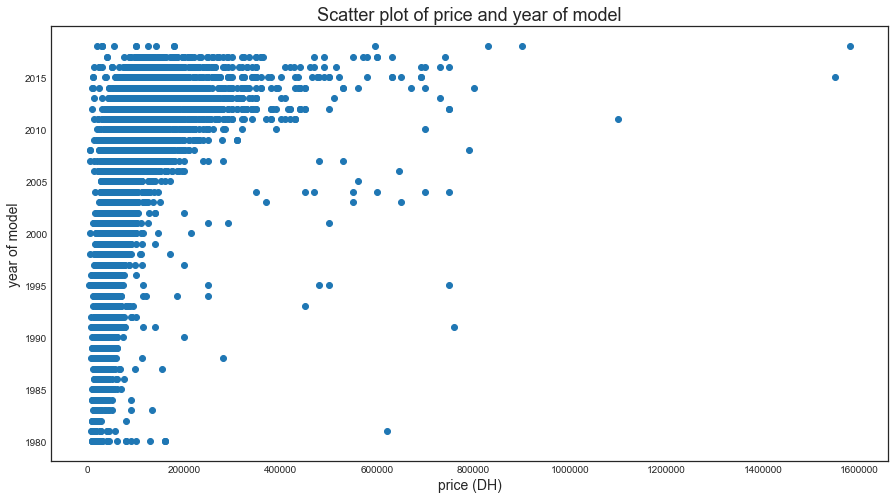

In [60]:
# here we set the figure size to 15x8
plt.figure(figsize=(15, 8))
# plot two values price per year_model
plt.scatter(df.price, df.year_model)
plt.xlabel("price (DH)", fontsize=14)
plt.ylabel("year of model", fontsize=14)
plt.title("Scatter plot of price and year of model",fontsize=18)
plt.show()

<p class="lead">As we can see from the plot above, the cars price increase respectivly by years, and more explicitly we can say that the more the car is recently released, the price augment, while in the other side the oldest cars still have a low price, and this is totally logical since whenever the cars become kind of old from the date of release, so their price start decrease.</p>

### Price distribution by mark

<p class="lead">Since we're looking to express the cars price by different features, so one of the important plot is to visualize how these prices differs between cars marks.</p> 

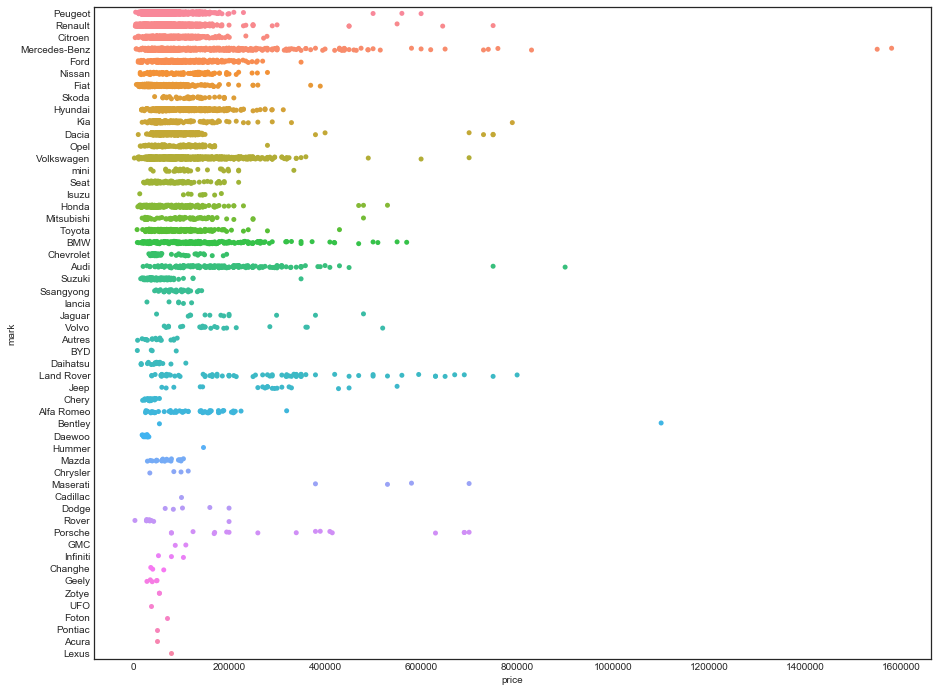

In [61]:
f, ax = plt.subplots(figsize=(15, 12))
sns.stripplot(data = df, x='price', y='mark', jitter=.1)
plt.show()

### Interpretation

<p class="lead">From the plot above, we can extract some the following insights : </p>
<ul class="lead" style="list-style: square;">
    <li>The popular marks such as Renault, Peugeot, Citroen, Dacia, Hyundai, KIA had a stable range of price, in other words they are not well diversified on the price axis.</li>
    <li>In the opposit side, we can clearly notice that the sophisticated cars are well distributed over the price axis such as the Mercedes-Benz, Land-Rover, Audi, Maserati, Porsche ..., which means that the more the cars from those classes, the more their price augments</li>
</ul>

### price distribution by fiscal_power

<p class="lead">Let's visualize the distributions of cars price by their fiscal power and grouping by the fuel_type, and look how it behaves</p>

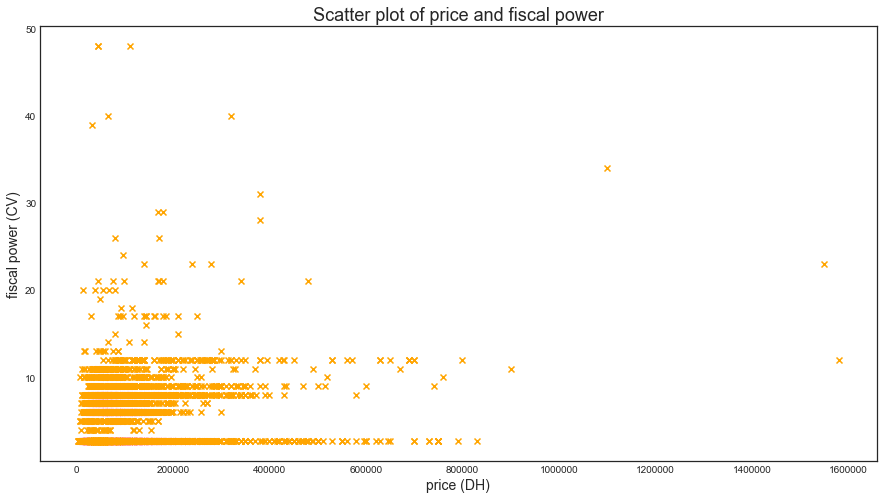

In [62]:
# here we set the figure size to 15x8
plt.figure(figsize=(15, 8))
# plot two values price per year_model
plt.scatter(df.price, df.fiscal_power, c='orange', marker='x')
plt.xlabel("price (DH)", fontsize=14)
plt.ylabel("fiscal power (CV)", fontsize=14)
plt.title("Scatter plot of price and fiscal power",fontsize=18)
plt.show()

<p class="lead">From the plot above we can notice clearly that there is a huge concentration of points in the range of [2800 DH,800000 DH], and [3 CV, 13 CV], which could be interpreted as first the huge domination of medium fiscal power cars in the market with correct price and second the more the fiscal power increase the price do too. </p>

### Top 20 Mark Distribution

<p class="lead">For the mark feature I have 54 marks, so plotting it all is not a good option for visual purpose, I will plot only the top 20 mark</p>

In [63]:
print('The length of unique marks feature is',len(df.mark.unique()))

The length of unique marks feature is 54


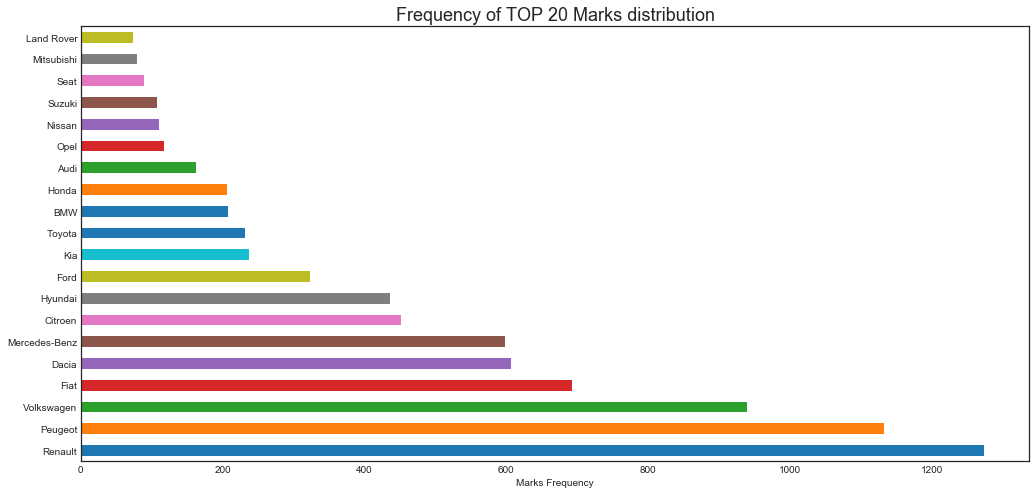

In [64]:
plt.figure(figsize=(17,8))
df.mark.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('Marks Frequency')
plt.title("Frequency of TOP 20 Marks distribution",fontsize=18)
plt.show()

### Price Distribution by fuel type

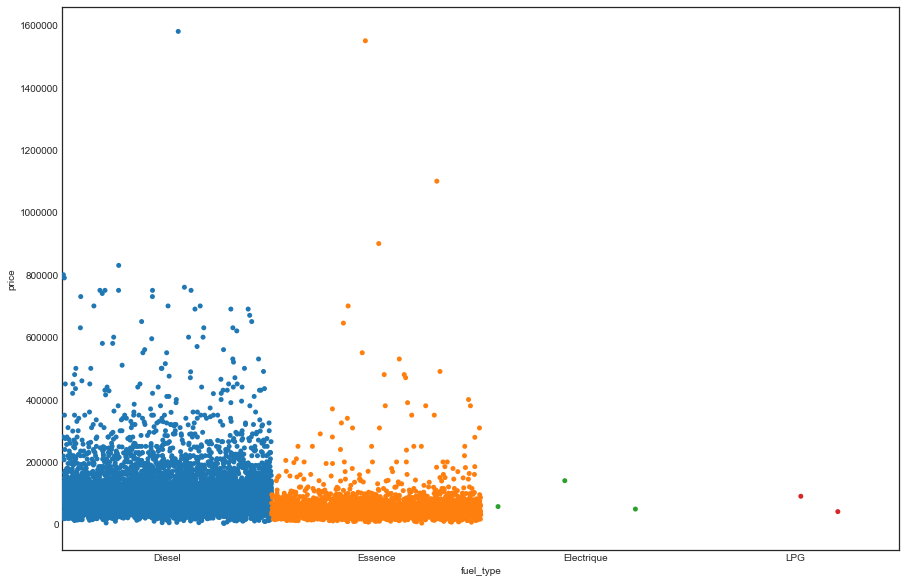

In [65]:
f, ax = plt.subplots(figsize=(15, 10))
sns.stripplot(data = df, x='fuel_type', y='price', jitter=.5)
plt.show()

#### Some Insights with Violin plot

<p class="lead">This chart is a combination of a Box Plot and a Density Plot that is rotated and placed on each side, to show the distribution shape of the data.</p>

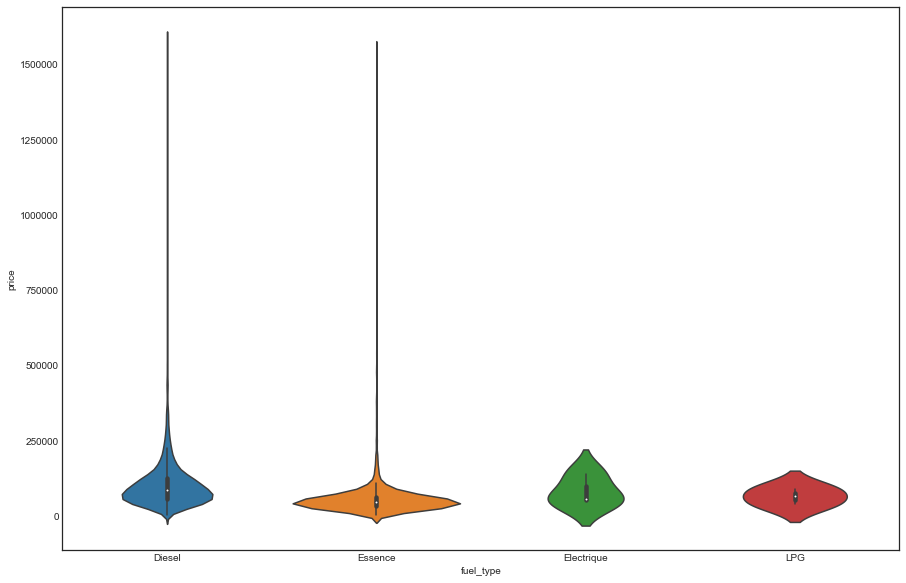

In [66]:
f, ax = plt.subplots(figsize=(15, 10))
sns.violinplot(data = df, x='fuel_type', y='price')
plt.show()

<p class="lead">From the plot above, we can clearly visualise a lot of information such as the minimum, maximum price for 'Diesel' cars and also get perception on the Median values, but more particularly what we got in violin plot other than teh box plot, is the density plot width known as Kernel Density Plots.</p>

#### Price distribution by mileage and fuel type

<p class="lead">In the following plot we will visualize the price distribution by the mileage values groupping by the fuel type and draw the best fit line that express the price (target feature) by mileage.</p> 

In [67]:
# define a color dictionarry by fuel_type
color_dict = {'Diesel': 'blue', 'Essence': 'orange', 'Electrique': 'yellow', 'LPG': 'magenta'}

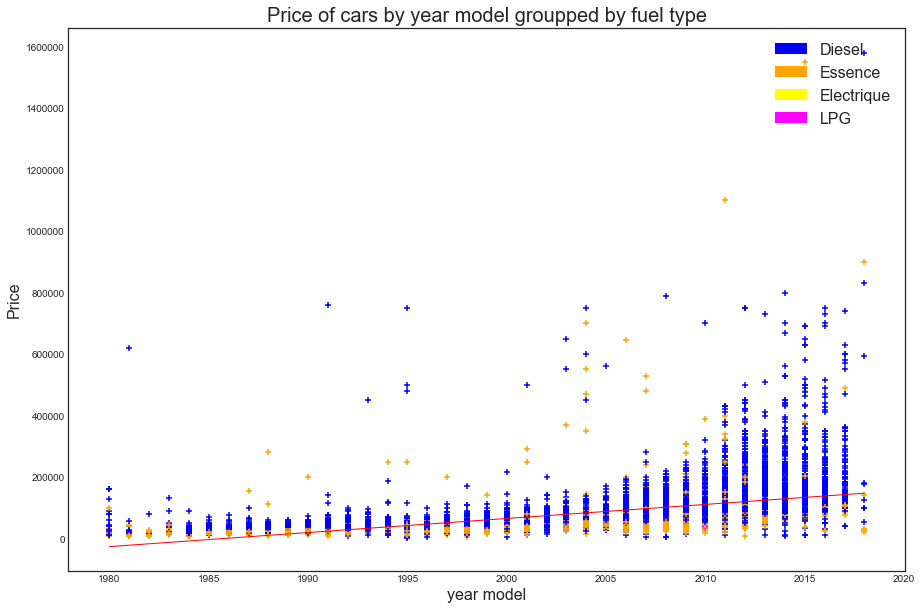

In [68]:
# set the figure size and plot the price & mileage points with the fit line in red
fig, ax = plt.subplots(figsize = (15,10))
plt.plot(np.unique(df.year_model), np.poly1d(np.polyfit(df.year_model, df.price, 1))(np.unique(df.year_model)), c = 'red', linewidth = 1)
plt.scatter(df.year_model, df.price, c = [color_dict[i] for i in df.fuel_type], marker='+')
# get the list of unique fuel type
fuel_type = df.fuel_type.unique()
recs = []
for i in fuel_type:
    recs.append(mpatches.Rectangle((2,2),1,1,fc=color_dict[i]))
    plt.legend(recs,fuel_type,loc=1, fontsize = 16)

plt.title('Price of cars by year model groupped by fuel type', 
          fontsize = 20)
plt.ylabel('Price', fontsize = 16)
plt.xlabel('year model', fontsize = 16)

xvals = ax.get_xticks()
ax.set_xticklabels(['{}'.format(int(x)) for x in xvals])

yvals = ax.get_yticks()
ax.set_yticklabels(['{}'.format(int(y)) for y in yvals])

plt.show()

<p class="lead">Although weak, it appears that there seems to be a positive relationship. Let's see what is the actual correlation between price and the other data points. We will look at this in 2 ways heatman for visualization and the correlation coefficient score.</p>

### Correlation matrix

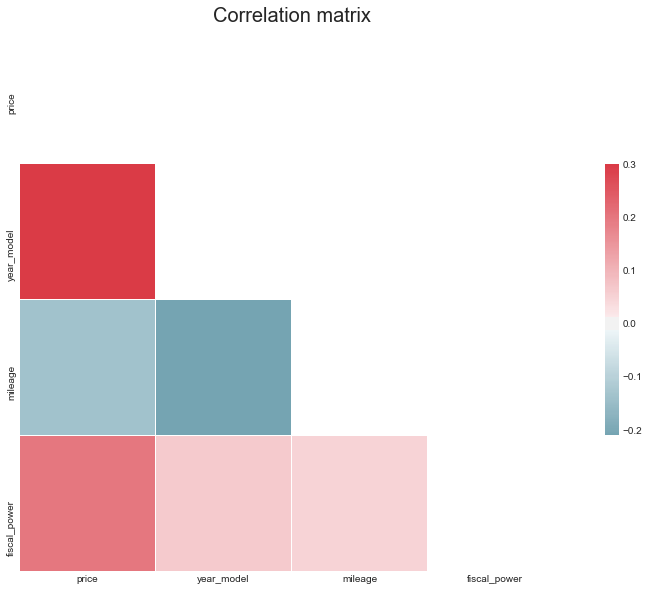

In [69]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))
# Compute the correlation matrix
corr = df.corr()
#print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix', 
          fontsize = 20)
plt.show()

#### Ads distribution by city

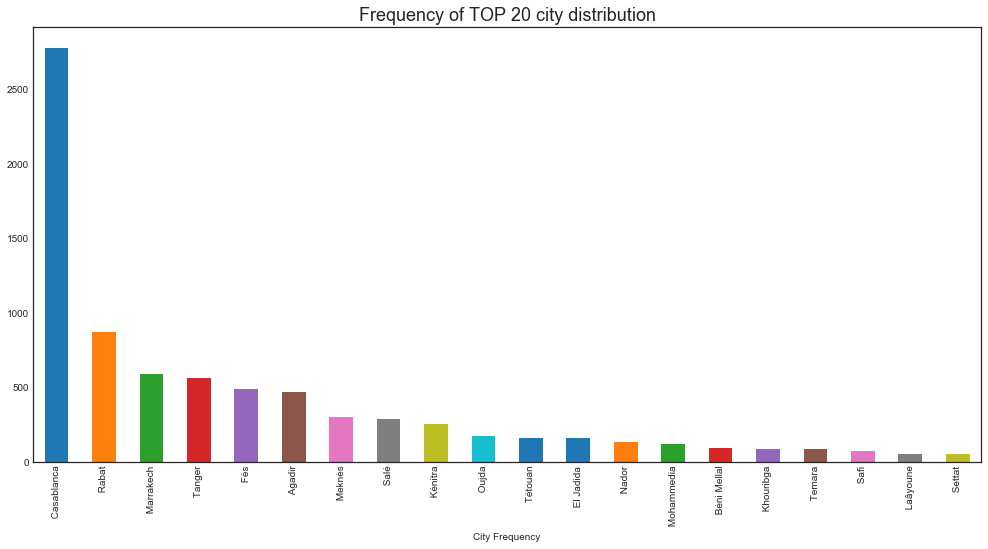

In [70]:
plt.figure(figsize=(17,8))
df.city.value_counts().nlargest(20).plot(kind='bar')
plt.xlabel('City Frequency')
plt.title("Frequency of TOP 20 city distribution",fontsize=18)
plt.show()

<p class="lead">We can clearly visualize that most of ad publications are coming from Casablanca & Rabat, which is quite normal due to the geographic distribution of the population in those cities, furthermore the economic position of those cities beyond the other ones</p>

# Data Modeling 

## KNN Regression

<p class="lead">For the moment we will use the K nearset neighbors regressor model with only numerical features, to get a basic view on our model how it behaves, then we will add other categorical features to improve it later.</p>

In [14]:
## create a dataframefor testing
data = df[df.price < 400000]

In [15]:
data.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,city
0,135000,2013,164999.5,Diesel,Peugeot,508,2.631837,Temara
1,53000,2008,37499.5,Diesel,Renault,Clio,2.631837,Safi
2,59000,2007,184999.5,Diesel,Citroen,C3,6.000000,Fès
3,88000,2010,37499.5,Diesel,Mercedes-Benz,220,2.631837,Nador
4,60000,2009,134999.5,Essence,Ford,Fiesta,7.000000,Fès


In [16]:
print(len(data))
print(len(df))

8456
8553


### Dealing with Categorical Features

<p class="lead">At the moment we still have 3 categorical features which are the fuel_type, mark and model the aim of this section is to pre process those features in order to make them numerical so that they will fit into our model.<br/>
In litterature there is two famous kind of categorical variable transformation, the first one is <b>label encoding</b>, and the second one is the <b>one hot encoding</b>, for this use case we will use the one hot position  and the reason why I will choose this kind of data labeling is because I will not need any kind of data normalisation later, and also This has the benefit of not weighting a value improperly but does have the downside of adding more columns to the data set. </p>

In [17]:
X = data[['year_model', 'mileage', 'fiscal_power', 'fuel_type', 'mark']]
Y = data.price
X = pd.get_dummies(data=X)

In [18]:
X.head()

,year_model,mileage,fiscal_power,fuel_type_Diesel,fuel_type_Electrique,fuel_type_Essence,fuel_type_LPG,mark_Acura,mark_Alfa Romeo,mark_Audi,...,mark_Skoda,mark_Ssangyong,mark_Suzuki,mark_Toyota,mark_UFO,mark_Volkswagen,mark_Volvo,mark_Zotye,mark_lancia,mark_mini
0,2013,164999.5,2.631837,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2008,37499.5,2.631837,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2007,184999.5,6.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2010,37499.5,2.631837,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2009,134999.5,7.000000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Splitting 

<p class="lead">Usually we split our data into three parts : Training , validation and Testing set, but for simplicity we will use only train and test with 20% in test size.</p>

In [19]:
# now we use the train_test_split function already available in sklearn library to split our data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 42)

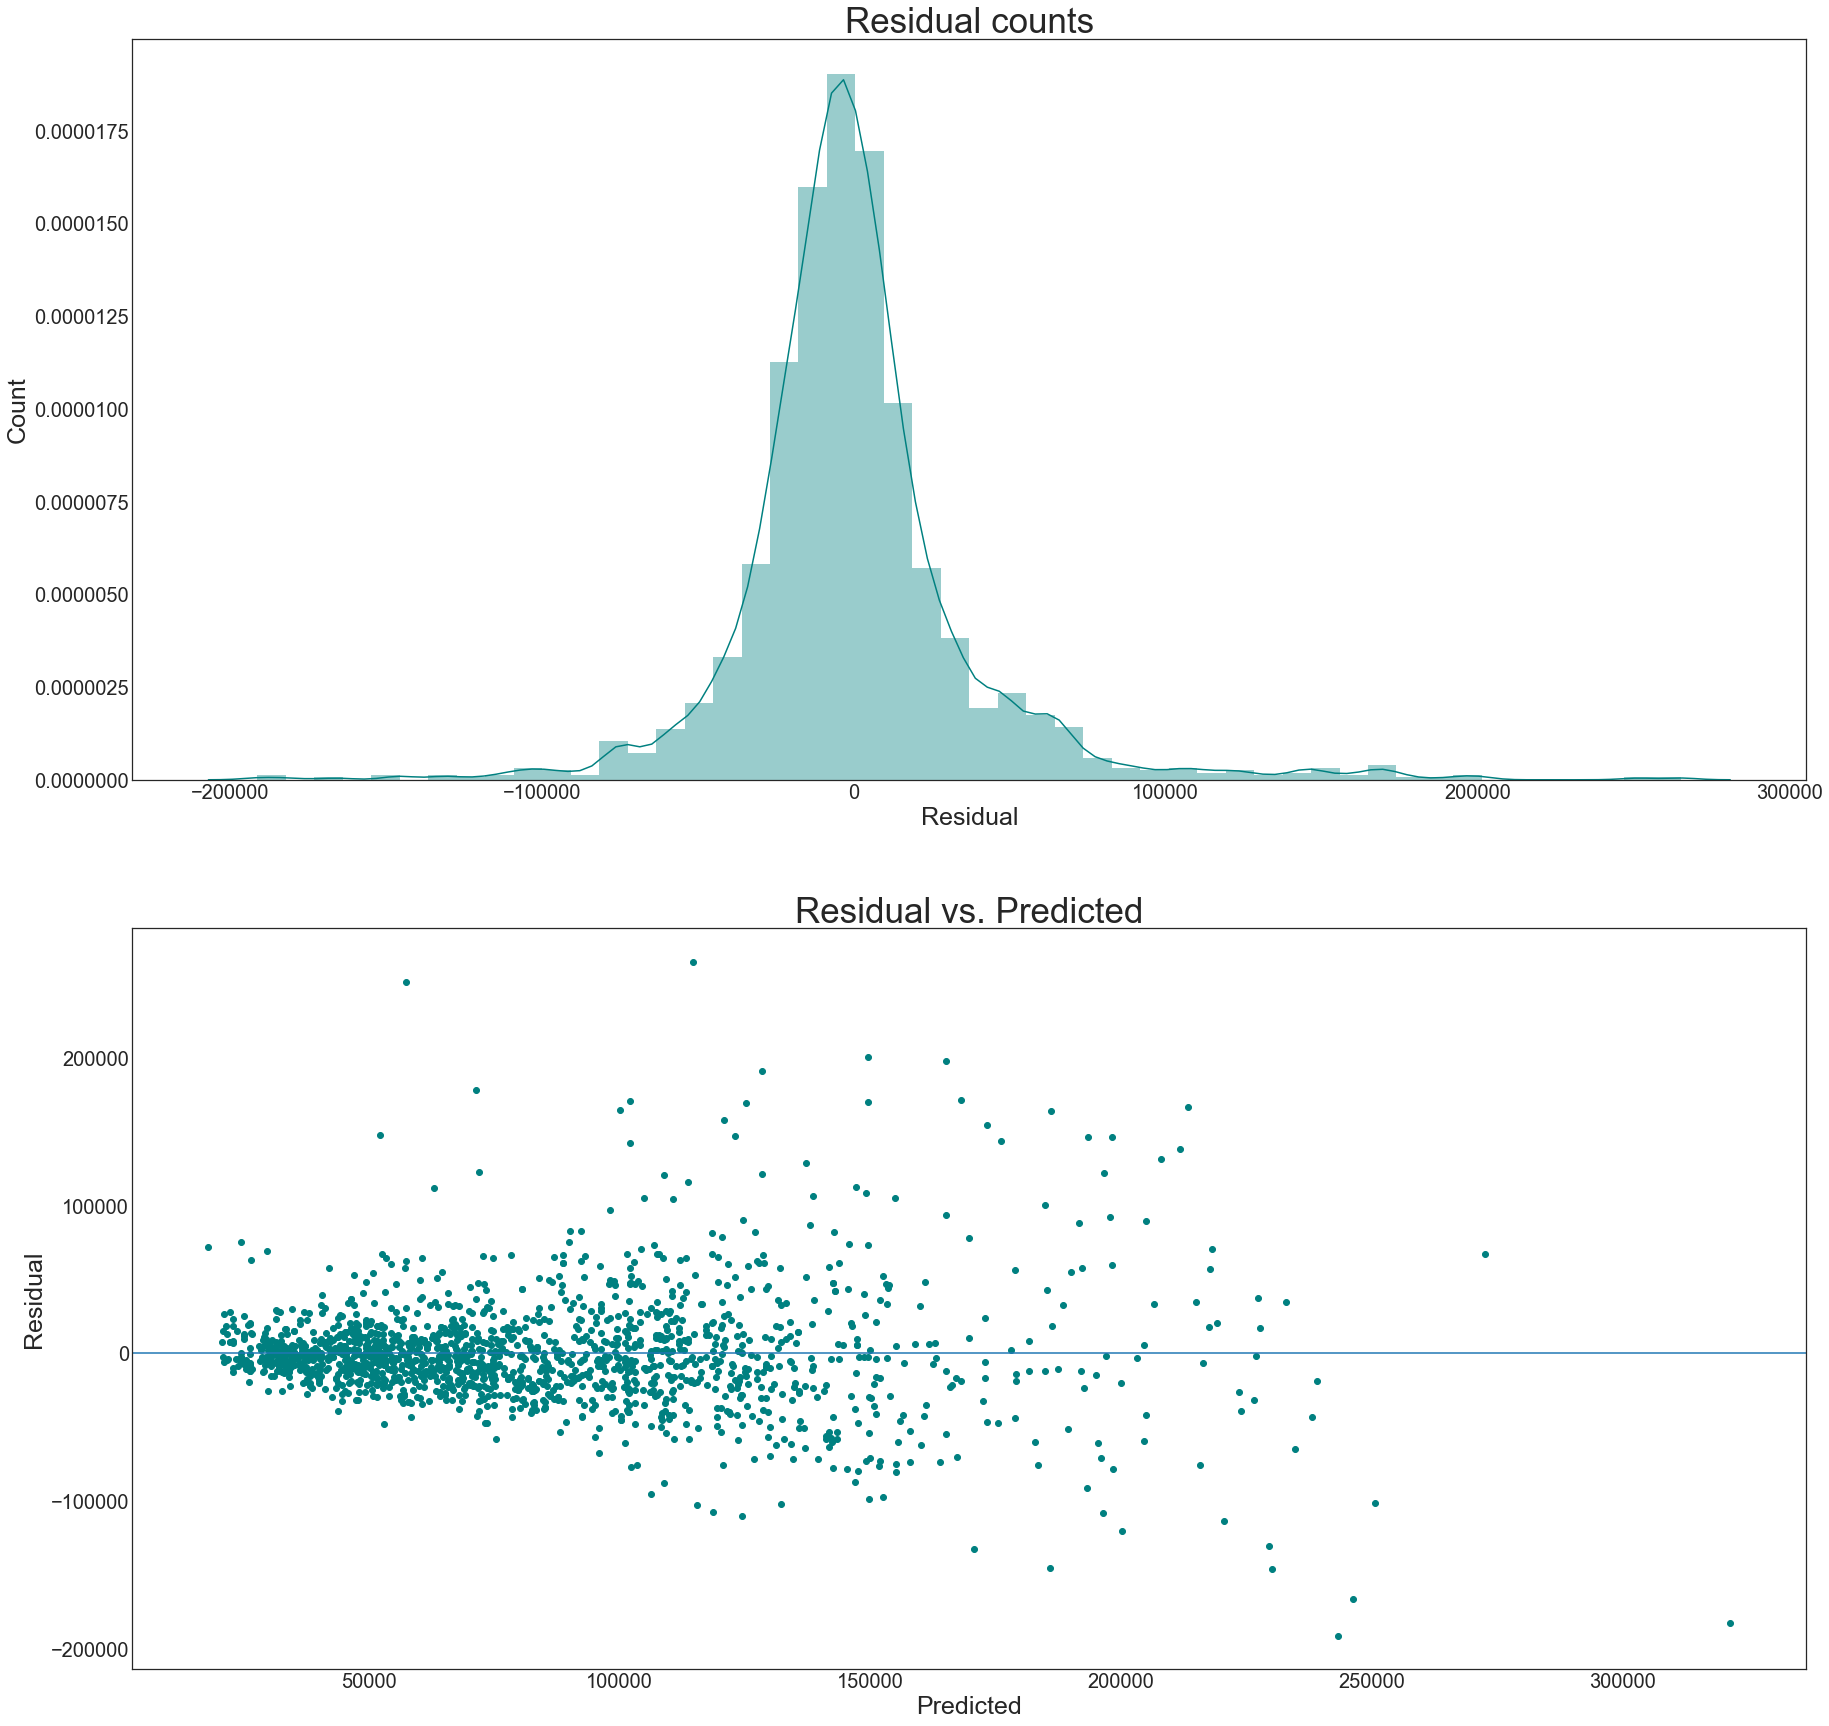

RMSE:
37709.6749493


In [21]:
from sklearn import neighbors
# the value of n_neighbors will be changed when we plot the histogram showing the lowest RMSE value
knn = neighbors.KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, Y_train)

predicted = knn.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [78]:
from sklearn.metrics import r2_score
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.56


<p class="lead">as we can see we got 56% in the r^2 score by using n_neighbors = 6, we still don't know if it's the optimal number of neighors or not, so for that we will plot a histogram of different Root Mean Squared Error by n_neighbors and see who's have the lowest RMSE value, and another thing is that the mean of cross validation values is very low which may indicate that our model had overfitted.</p>

In [79]:
rmse_l = []
num = []
for n in range(2, 16):
    knn = neighbors.KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, Y_train)
    predicted = knn.predict(X_test)
    rmse_l.append(np.sqrt(mean_squared_error(Y_test, predicted)))
    num.append(n)

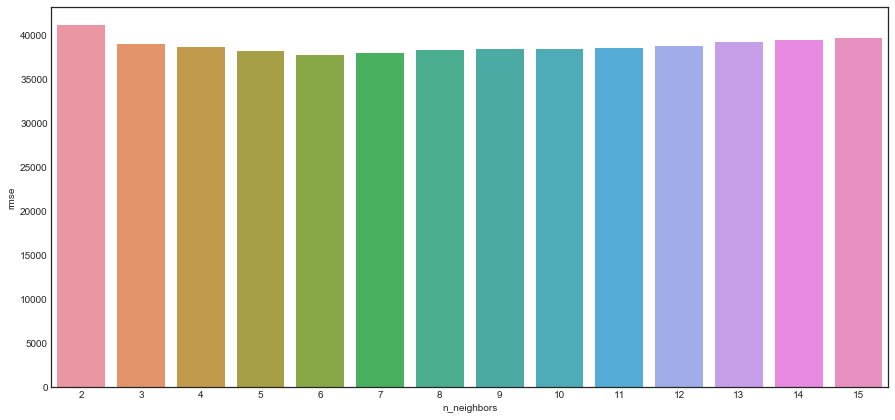

In [80]:
df_plt = pd.DataFrame()
df_plt['rmse'] = rmse_l
df_plt['n_neighbors'] = num
ax = plt.figure(figsize=(15,7))
sns.barplot(data = df_plt, x = 'n_neighbors', y = 'rmse')
plt.show()

<p class="lead">It appears that 6 nearest neighbors is the optimal number of neighbors.</p>

## Descision Tree Regression

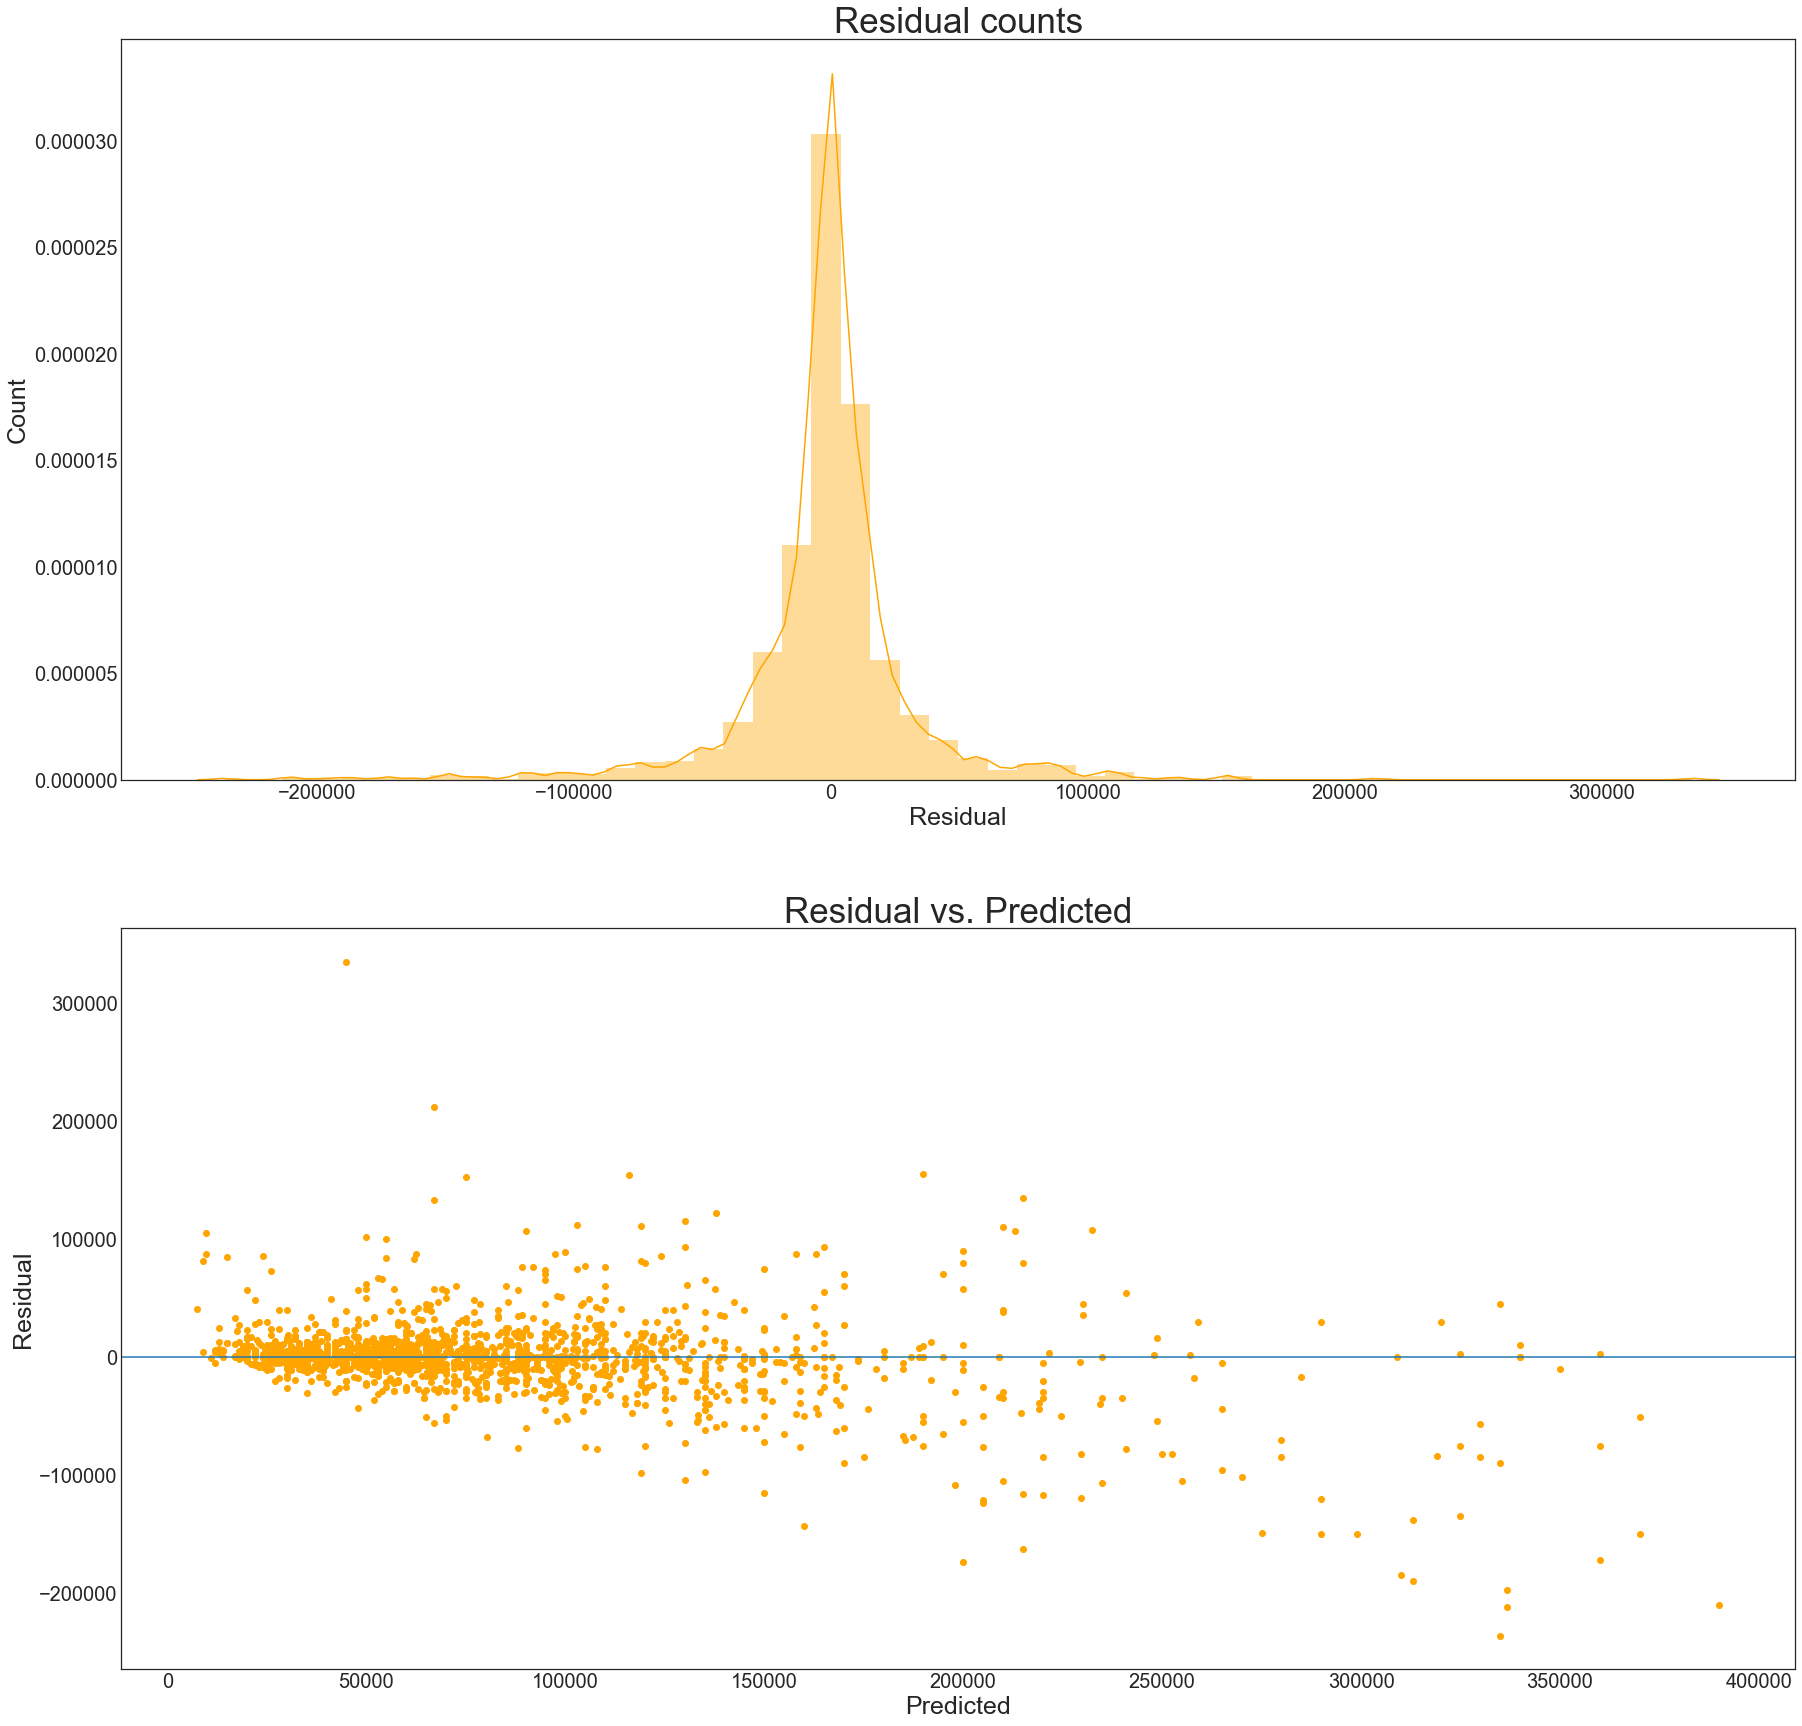

RMSE:
34685.4708114


In [25]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_features='auto')
dtr.fit(X_train, Y_train)
predicted = dtr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [26]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.63


<p class="lead">The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) (or sometimes root-mean-squared error) is a frequently used measure of the differences between values (sample and population values) predicted by a model or an estimator and the values actually observed. The RMSD represents the sample standard deviation of the differences between predicted values and observed values. These individual differences are called residuals when the calculations are performed over the data sample that was used for estimation, and are called prediction errors when computed out-of-sample. The RMSD serves to aggregate the magnitudes of the errors in predictions for various times into a single measure of predictive power. RMSD is a measure of accuracy, to compare forecasting errors of different models for a particular data and not between datasets, as it is scale-dependent. ~ WikiPedia<br>
By comparing the Tree Regression with the KNN Regression we can see that the RMSE was reduced from 37709 to 34392 which let us say that this model is more accurate than the last one, but that's not all of it, we still have to test other regression algorithm to check if there is any improvement in result.
</p>

## Interpretation

<p class="lead">By looking at the last RMSE score we've vast improvements, as you can see from the "Residual vs. Predicted" that the predicted score is closer to zero and is tighter around the lines which means that we are guessing alot closer to the price.</p>

# What about Simple Linear Regression

## Linear Regression 

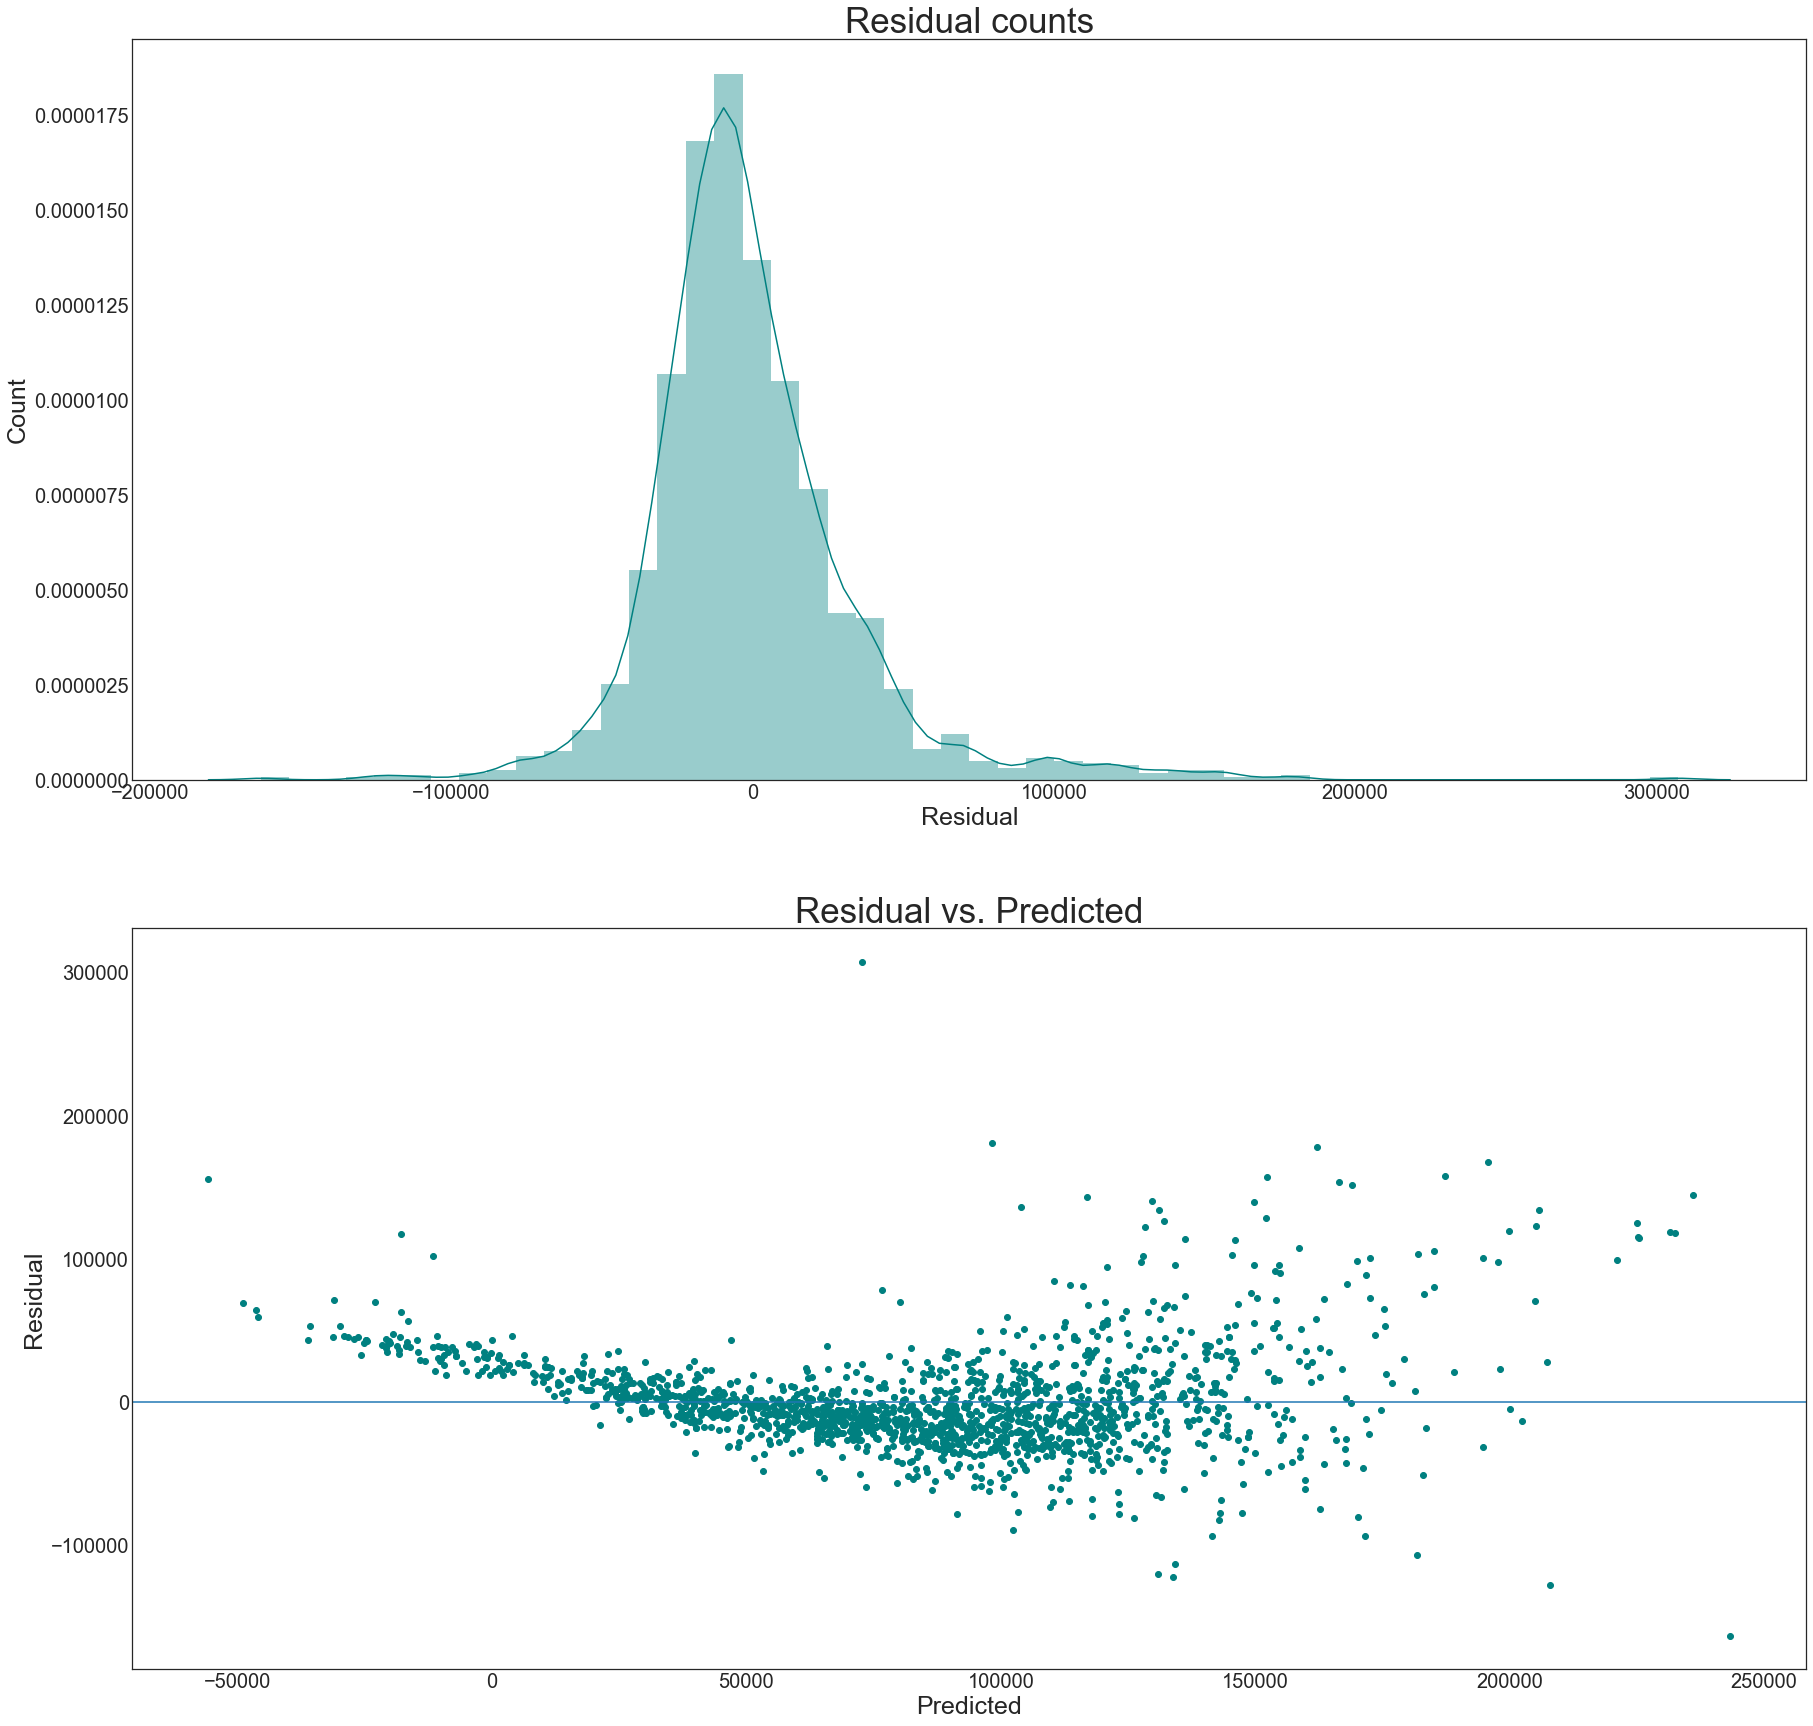

RMSE:
34865.0732413


In [29]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

predicted = regr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [30]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.62


## Boosting

<p class="lead">Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms which convert weak learners to strong ones. Boosting is based on the question posed by Kearns and Valiant (1988, 1989): Can a set of weak learners create a single strong learner? A weak learner is defined to be a classifier which is only slightly correlated with the true classification (it can label examples better than random guessing). In contrast, a strong learner is a classifier that is arbitrarily well-correlated with the true classification. ~ WikiPedia)
<br>Let's see if boosting can improve our scores.</p>

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

r_sq = []
deep = []
mean_scores = []

#loss : {‘ls’, ‘lad’, ‘huber’, ‘quantile’}
for n in range(3, 11):
    gbr = GradientBoostingRegressor(loss ='ls', max_depth=n)
    gbr.fit (X, Y)
    deep.append(n)
    r_sq.append(gbr.score(X, Y))
    mean_scores.append(cross_val_score(gbr, X, Y, cv=12).mean())

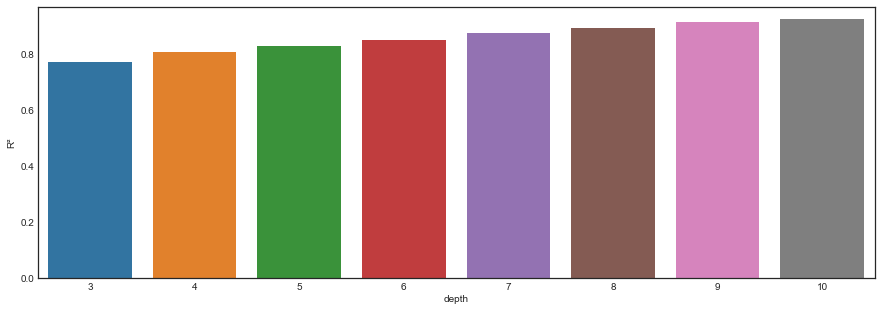

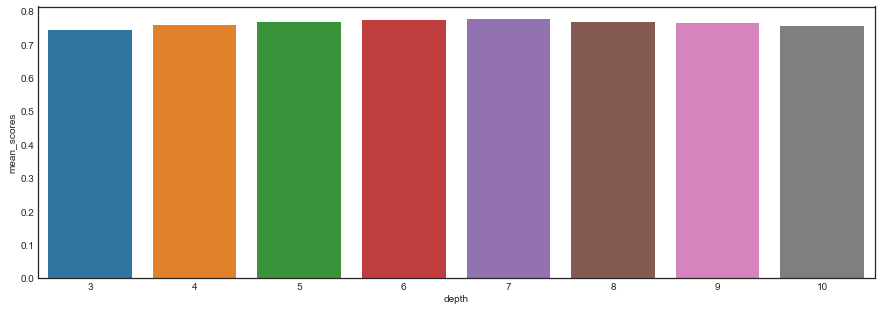

In [40]:
plt_gbr = pd.DataFrame()

plt_gbr['mean_scores'] = mean_scores
plt_gbr['depth'] = deep
plt_gbr['R²'] = r_sq

f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data = plt_gbr, x='depth', y='R²')
plt.show()

f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data = plt_gbr, x='depth', y='mean_scores')
plt.show()

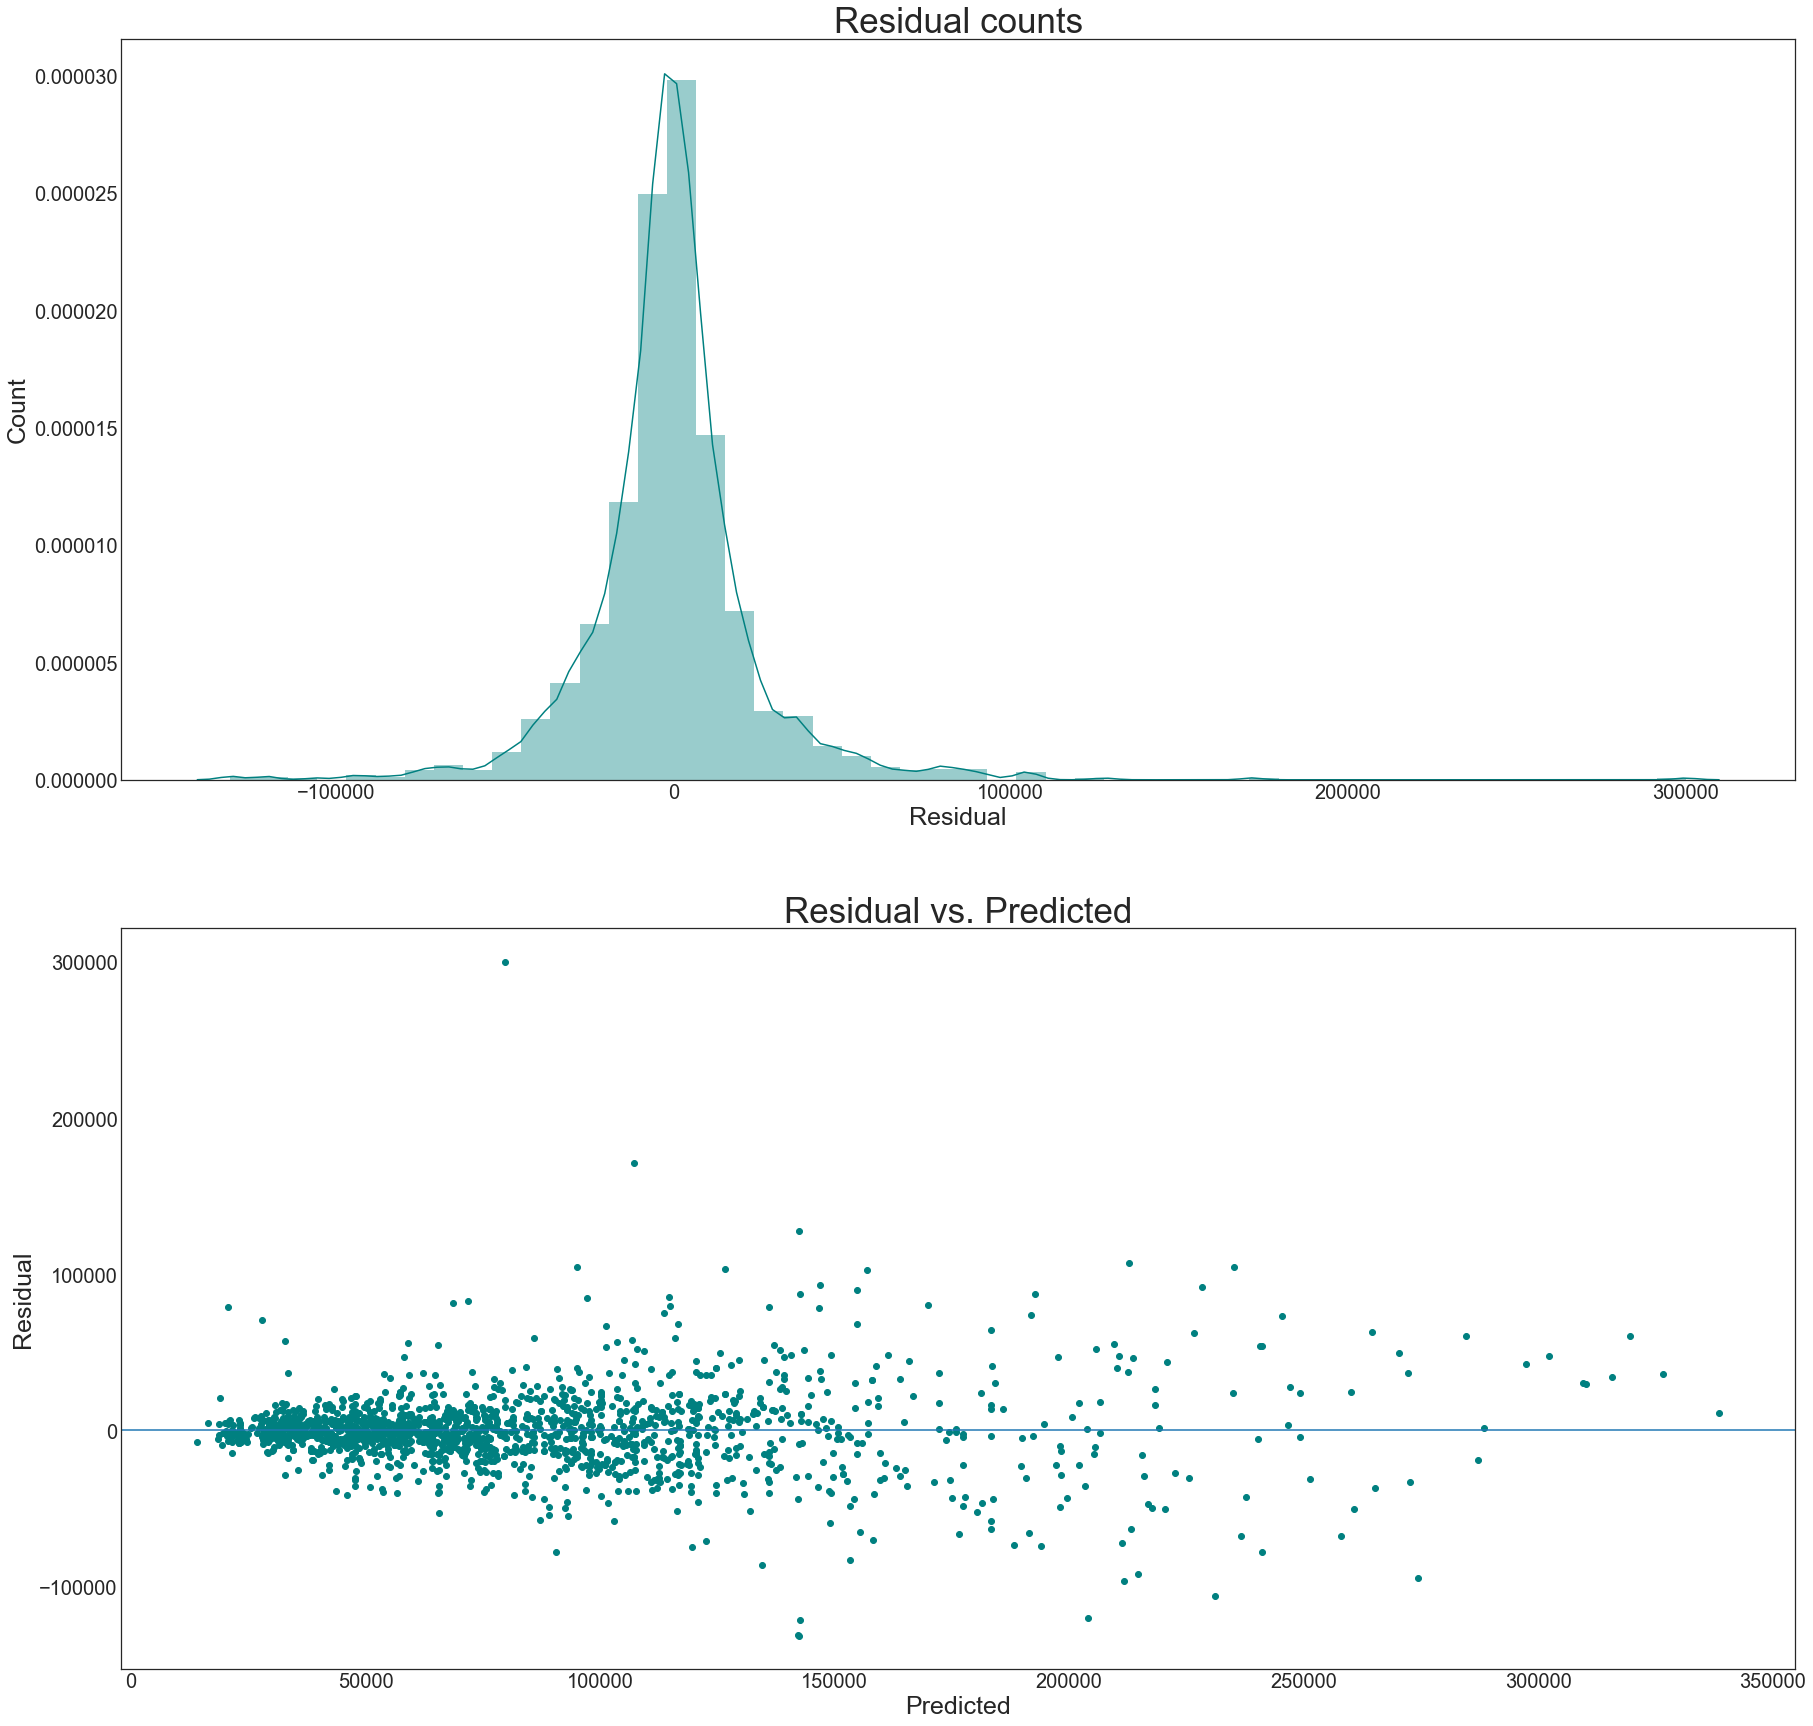


Cross Validation Scores:
[ 0.8037864   0.77305086  0.80276727  0.73398494  0.75046888  0.85823915
  0.80724536  0.73314473  0.77554294  0.74125608  0.67662316  0.81100566]

Mean Score:
0.772259618584

RMSE:
25164.1047571


In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbr = GradientBoostingRegressor(loss ='ls', max_depth=6)
gbr.fit (X_train, Y_train)
predicted = gbr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

rmse = np.sqrt(mean_squared_error(Y_test, predicted))
scores = cross_val_score(gbr, X, Y, cv=12)

print('\nCross Validation Scores:')
print(scores)
print('\nMean Score:')
print(scores.mean())
print('\nRMSE:')
print(rmse)

In [87]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

Variance score: 0.80


### Prediction VS Real price histogram

<p class="lead">First of all we reshape our data to a 1D array then we plot the histogram doing the comparison between the real price and the predicted ones.</p>

In [83]:
A = Y_test.reshape(-1, 1)
B = predicted.reshape(-1, 1)

/home/pacman/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


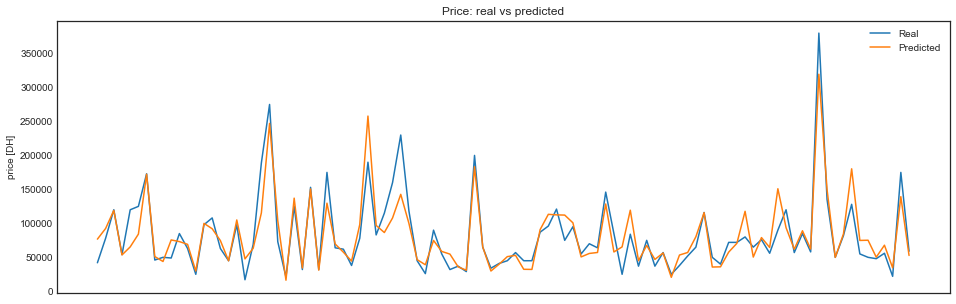

In [84]:
plt.rcParams['figure.figsize'] = 16,5
plt.figure()
plt.plot(A[-100:], label="Real")
plt.plot(B[-100:], label="Predicted")
plt.legend()
plt.title("Price: real vs predicted")
plt.ylabel("price [DH]")
plt.xticks(())
plt.show()

<p class="lead">We can notice clearly that the two line (real vs predicted) fit each other well, with some small differences which let us say that we did a good improvement compared with the first model.</p>

## Model Evaluation

<p class="lead">It appears that the Gradient Boosting model regressor win the battle with the lowest RMSE value and the highest R^2 score. In the following table we will do a benchmarking resuming all the models tested above.</p>

<table class="table table-bordered">
    <thead>
      <tr>
        <th>Model</th>
        <th>Variance Score</th>
        <th>RMSE</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>KNN</td>
        <td>0.56</td>
        <td>37709.67</td>
      </tr>
      <tr>
        <td>Multiple Linear Regression</td>
        <td>0.62</td>
        <td>34865.07</td>
      </tr>
      <tr style="color: green">
        <td>Gradient Boosting</td>
        <td>0.80</td>
        <td>25176.16</td>
      </tr>
      <tr>
        <td><b>Decision Tree</b></td>
        <td><b>0.63</b></td>
        <td><b>34551.17</b></td>
      </tr>
    </tbody>
</table>

<p class="lead">Since the Gradient Boosting regressor is the winner, we will now inspect its coeficients and interceptors.</p>

## Let's predict an observation never seen before

<p class="lead">To do that we first build a fucntion that takes a simple user input and transform it to a one hot encoding.</p>

In [39]:
# user_input = [2010, 124999.5, 6, 'Diesel', 'BMW']
user_input = {'year_model':2006, 'mileage':82499.5, 'fiscal_power':6, 'fuel_type':'Diesel', 'mark':'Dacia'}
def input_to_one_hot(data):
    # initialize the target vector with zero values
    enc_input = np.zeros(61)
    # set the numerical input as they are
    enc_input[0] = data['year_model']
    enc_input[1] = data['mileage']
    enc_input[2] = data['fiscal_power']
    ##################### Mark #########################
    # get the array of marks categories
    marks = df.mark.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'mark_'+data['mark']
    # search for the index in columns name list 
    mark_column_index = X.columns.tolist().index(redefinded_user_input)
    #print(mark_column_index)
    # fullfill the found index with 1
    enc_input[mark_column_index] = 1
    ##################### Fuel Type ####################
    # get the array of fuel type
    fuel_types = df.fuel_type.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'fuel_type_'+data['fuel_type']
    # search for the index in columns name list 
    fuelType_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[fuelType_column_index] = 1
    return enc_input

In [40]:
print(input_to_one_hot(user_input))

[  2.00600000e+03   8.24995000e+04   6.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [41]:
a = input_to_one_hot(user_input)

In [42]:
price_pred = gbr.predict([a])

In [43]:
price_pred[0]

59156.004150951689

### Save the best Model

In [44]:
from sklearn.externals import joblib

joblib.dump(gbr, 'model.pkl')

['model.pkl']

In [45]:
gbr = joblib.load('model.pkl')

In [47]:
print("the best price for this Dacia is",gbr.predict([a])[0])

the best price for this Dacia is 59156.004151


### Build a REST API

In [48]:
import requests, json

In [50]:
url = "http://127.0.0.1:8080/api"
data = json.dumps({'year_model':2014, 'mileage':12499.5, 'fiscal_power':7, 'fuel_type':'Diesel', 'mark':'Mercedes-Benz'})

r = requests.post(url, data)

print(r.json())

{'results': [290275.6155041407]}


In [52]:
r.json()['results'][0]

290275.6155041407